# CA2 - Statistical Insights on Agriculture in Ireland and EU

## Overview

In this notebook, it is analysed the agriculture data on the following areas from Ireland and other similar countries in the EU.

- Organic Farming Growth
- Import/Export of Agriculture Goods
- Food Price Inflation

The datasets were analysed and the following statistical techniques were applied:

- Confidence interval

- Hypoteshis tests:
    - Shapiro
    - Non-parametric tests:
        - Kruskal
        - Mannwhitneyu
        - Wilcoxon

This notebook is divided into two parts (i) Confidence Interval and (ii) Hypothesis tests. 

In the first part, the Irish organic farming data was studied to find a confidence interval for the whole EU population proportion.

In the second part, the Import/Export and Food Price Inflation datasets were analysed against inferential statistics tests.

## Auxiliary Functions

In this section, the auxiliary functions used in this notebook were implemented.

In [166]:
from math import sqrt
from scipy import stats
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')

def isDistNormal(data_col):
    """
    This function applies the Shapiro test to decide
    if the data is from a normal distribution or not.

    Parameters:
        data_col (data series): DataSeries
    Return:
        (bool): True if data is normal, false otherwise.
    """     
    shapiro_test = stats.shapiro(data_col)
    if shapiro_test.pvalue > 0.05:
        return True
    return False
    
def plotColGraph(data_col):
    """
    This function plots a graph for the column specified
    in the input.

    Parameters:
        data_col (data series): DataSeries
    """    
    stats.probplot(data_col, plot=plt)
    plt.figure()

def removeEmptyRows(data, col):
    """
    This function removes empty rows from data frame based on the
    specified column.

    Parameters:
        data (pd.DataFrame): DataFrame
    Returns:
        data without empty
    """
    null_filter = data[col].notnull()
    return data[null_filter]

def getNonEmptyValues(col_data):
    """
    This function removes empty rows from data frame series (column).

    Parameters:
        col_data (pd.Series): DataFrame series
    Returns:
        Non empty rows
    """
    null_filter = col_data.notnull()
    return col_data[null_filter]

def confidenceIntervalTStudent(mean, std, n, alpha=.97):
    """
    This function calculates the confidence interval for the given paramters.
    
    Parameters:
        mean (num): Average of the sample
        std  (num): Standard deviation of the sample
        n    (int): Size of sample
    Returns:
        (num, num): (lower limit, upper limit)
    """
    t = abs(stats.t.ppf((1 - alpha)/2, n - 1))
    interval = t * std/sqrt(n - 1)
    return mean - interval, mean + interval

def getStatsArray(stats_dict, val='mean'):
    """
    This function extracts the stats from the dictionary into a numpy array.
    
    Parameters:
        stats_dict (dict): Dictionary with custom statistics
        val         (str): Measurement to return (must be one of [mean, std, count, ll, ul])
    Returns:
        np array with values as per parameter or empty if input is invalid.
    """
    if val not in ['mean', 'std', 'count', 'll', 'ul']:
        return np.array([])
    return np.array(list([stats_dict[year][val] for year in stats_dict]))

## Confidence Interval

For this study, it was used the Organic Farming data from Eurostat portal.

The idea of this analysis was to use the sample data on the growth of organic farming in several European countries to obtain a confidence interval of the same growth in Europe (population) across the years.

The steps of this analysis is detailed in the section below.

### Organic Farming

Eurostat provides yearly data on the percent of UAA (utilized agricultural area) under organic farming per country in Europe.

Problem: What is the average percent of land of the total UAA that is occupied by organic farming in Europe as a whole? How does it compare to Ireland?

- Available data:

    * Percent of total UAA under organic farming by year by country in Europe.

- Approach:

    * Use countries data (samples) to find a confidence interval for the total UAA under organic farming in Europe (population) per year. 

    * Compare the growth rate of organic farming in Europe with Ireland.

### Data Preparation

In this section, the dataset is cleand and prepared for the statistical analysis. 

The raw data was cleansed to remove unnecessary columns and to convert the percent data into numeric data type. 

This step was necessary to fit the dataset into the functions used to calculate the confidence interval.

It was created two data frames, one with the whole dataset and another one with Ireland's data only.

This step was done to compare Ireland's organic farming growht with the estimated confidence interval for Europe.

After that the data was checked for nulls. Null values can impact on the analysis, so they were removed from the dataset.

In [161]:
# showing raw dataset
dataset = pd.read_csv('./datasets/organic-farming.csv')
dataset.head()

,GEO (Codes),GEO (Labels),2000,2001,2002,2003,2004,2005,2006,2007,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
0,EU,"European Union (EU6-1958, EU9-1973, EU10-1981,...",3.0,:,3.8,4.0,:,3.8,4.1,4.0,...,5.4,5.66,5.70,5.78,6.20,6.68,7.03,7.50,7.92,9.08
1,EU27_2020,European Union - 27 countries (from 2020),:,:,:,:,:,:,:,:,...,:,5.88,5.91,6.08,6.56,7.09,7.48,8.03,8.49,9.08
2,EU28,European Union - 28 countries (2013-2020),:,:,:,:,:,:,:,:,...,:,5.64,5.70,5.78,6.20,6.68,7.03,7.50,7.92,:
3,BE,Belgium,1.5,1.6,2.1,1.7,1.7,1.7,2.1,2.4,...,4.1,4.48,4.67,5.00,5.17,5.80,6.28,6.56,6.85,7.25
4,BG,Bulgaria,:,:,:,:,:,0.2,0.1,0.3,...,0.5,0.76,1.13,0.96,2.37,3.20,2.72,2.56,2.34,2.30


In [162]:
# cleaning rows to keep only countries data
codesCol = dataset.keys()[0]
dataset = dataset.loc[~dataset[codesCol].str.contains('EU')]

# getting Ireland's data only
dataset_ire = dataset.loc[dataset[codesCol] =='IE']

# removing first two columns with labels
dataset = dataset.iloc[:,2:]
dataset_ire = dataset_ire.iloc[:,2:]

# converting data into numbers
columns = dataset.keys()
for c in columns:
    dataset[c] = pd.to_numeric(dataset[c], errors='coerce')
    dataset_ire[c] = pd.to_numeric(dataset_ire[c], errors='coerce')

dataset.describe()

,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
count,16.000000,16.000000,17.000000,20.000000,26.000000,29.000000,28.000000,28.000000,28.000000,28.000000,...,27.000000,30.000000,33.000000,33.000000,34.000000,33.000000,34.000000,33.000000,34.000000,33.000000
mean,3.537500,3.968750,4.211765,4.380000,4.111538,4.475862,4.667857,4.850000,5.182143,5.592857,...,6.311111,6.631000,6.146970,6.339394,6.532059,7.208788,7.424706,8.031212,8.236176,8.639091
std,3.523043,3.561782,3.463720,3.452017,3.380808,3.624781,3.687120,3.651129,3.824681,4.178865,...,4.816744,4.676364,4.862754,5.001229,5.175618,5.529636,5.996805,6.265392,6.544499,6.679408
min,0.600000,0.700000,0.700000,0.200000,0.000000,0.100000,0.100000,0.300000,0.300000,0.200000,...,0.200000,0.320000,0.060000,0.270000,0.170000,0.210000,0.250000,0.350000,0.290000,0.290000
25%,1.200000,1.600000,2.100000,2.150000,1.725000,1.900000,2.000000,1.875000,2.075000,2.550000,...,2.850000,3.200000,2.650000,2.670000,2.490000,3.200000,2.965000,3.330000,3.017500,3.520000
50%,1.800000,2.300000,2.600000,3.450000,3.400000,4.200000,4.000000,4.600000,5.200000,5.150000,...,5.400000,5.540000,5.230000,5.050000,5.055000,6.050000,6.370000,6.940000,7.455000,8.000000
75%,5.900000,6.375000,6.500000,6.550000,6.250000,6.800000,7.200000,6.700000,7.350000,7.650000,...,8.300000,8.920000,8.180000,9.290000,9.315000,9.750000,9.825000,10.010000,10.905000,11.670000
max,13.800000,14.000000,14.500000,15.400000,16.000000,16.700000,16.700000,17.000000,17.400000,18.500000,...,19.600000,18.620000,18.400000,19.350000,20.300000,21.250000,23.370000,24.080000,25.330000,25.690000


In [163]:
# checking empty values on full dataset
dataset.isnull().sum()

2000    18
2001    18
2002    17
2003    14
2004     8
2005     5
2006     6
2007     6
2008     6
2009     6
2010     7
2011     7
2012     4
2013     1
2014     1
2015     0
2016     1
2017     0
2018     1
2019     0
2020     1
dtype: int64

In [164]:
# checking empty values on ireland dataset
dataset_ire.isnull().sum()

2000    0
2001    0
2002    0
2003    0
2004    0
2005    0
2006    0
2007    0
2008    0
2009    0
2010    0
2011    0
2012    0
2013    0
2014    0
2015    0
2016    0
2017    0
2018    0
2019    0
2020    0
dtype: int64

For each year (column) it was calculated the standard deviation and average of the percent of land under organic farming in all European countries in the dataset. Null data were removed.

This way, it was possible to calculate the confidence interval of the population (Europe) per year.

For each year, it was stored the standard deviation, mean, lower and upper limit obtained from the confidence interval calculation.

In [165]:
# calculate descriptive stats (standard deviation and average) of the sample data - without nulls
stats_dict = {}
for c in columns:
    dataset_c = getNonEmptyValues(dataset[c])
    desc_stats = dataset_c.describe()
    stats_dict[c] = {'std': desc_stats.loc['std'], 'mean': desc_stats.loc['mean'], 'count': desc_stats.loc['count']}
    stats_dict[c]['ll'], stats_dict[c]['ul'] = confidenceIntervalTStudent(desc_stats.loc['mean'], desc_stats.loc['std'],  desc_stats.loc['count'])
stats_dict

{'2000': {'std': 3.523043192090233,
  'mean': 3.5375,
  'count': 16.0,
  'll': 1.357074337123163,
  'ul': 5.717925662876837},
 '2001': {'std': 3.561782091406866,
  'mean': 3.96875,
  'count': 16.0,
  'll': 1.7643486758507634,
  'ul': 6.173151324149236},
 '2002': {'std': 3.4637195240343104,
  'mean': 4.211764705882352,
  'count': 17.0,
  'll': 2.149513404003599,
  'ul': 6.274016007761105},
 '2003': {'std': 3.4520169542792773,
  'mean': 4.380000000000001,
  'count': 20.0,
  'll': 2.522371465936437,
  'ul': 6.237628534063564},
 '2004': {'std': 3.3808078233554686,
  'mean': 4.111538461538461,
  'count': 26.0,
  'll': 2.5556031095587604,
  'ul': 5.667473813518162},
 '2005': {'std': 3.6247812911770265,
  'mean': 4.475862068965518,
  'count': 29.0,
  'll': 2.909647541498958,
  'ul': 6.042076596432078},
 '2006': {'std': 3.687120081764967,
  'mean': 4.667857142857144,
  'count': 28.0,
  'll': 3.0422555663825674,
  'ul': 6.29345871933172},
 '2007': {'std': 3.651128694080879,
  'mean': 4.84999999

### Data Visualization

In this section, the data obtained in the previous step is plotted in a graph.

This way, it's possible to easily observe how the size of organic farming has grown in Ireland as compared to Europe, using the confidence interval calculated from the sample data.

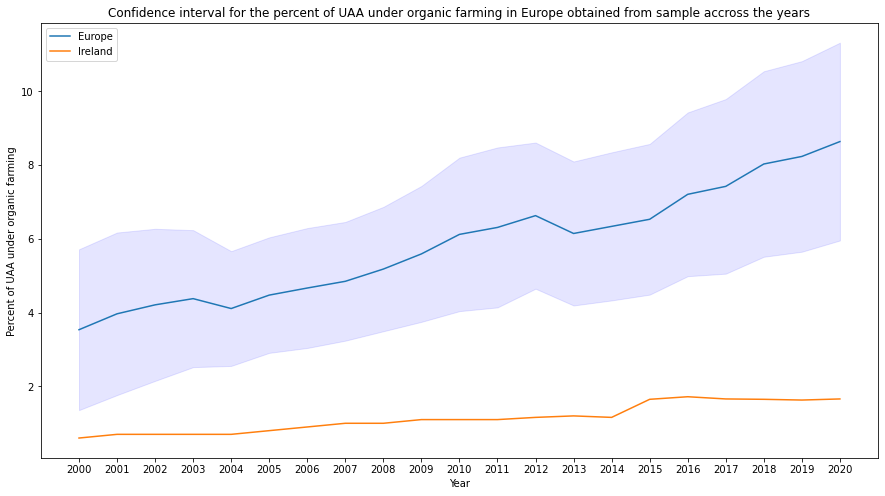

In [167]:
# get x data
x = np.array(list(stats_dict.keys()))

# get y data
y = getStatsArray(stats_dict, 'mean')

# get ll data
ll = getStatsArray(stats_dict, 'll')

# get ul data
ul = getStatsArray(stats_dict, 'ul')

# get ireland's data only
ire = dataset_ire.to_numpy().reshape(x.shape[0],)

# plot graph with europe and irelands data
fig, ax = plt.subplots(figsize=(15, 8))
ax.plot(x, y, label='Europe')
ax.set_title('Confidence interval for the percent of UAA under organic farming in Europe obtained from sample accross the years')
ax.set_xlabel('Year')
ax.set_ylabel('Percent of UAA under organic farming')
ax.fill_between(x, ll, ul, color='b', alpha=.1)
ax.plot(x, ire, label='Ireland')
plt.legend(loc=2)

## Hypothesis Tests

Statistical tests:

* Non-parametric:
  - Wilcoxon Sign Test
  - Kruskal-Wallis
  - U-Mann Whitman

* Parametric Tests - Normal dist/T student
  - Shapiro (test is normal)
  - T-tests (2 populations)
  - Analysis of Variance
    - Anova/Anova 2 way (More than 2 populations/F-test)

### Agriculture Import/Export Balance

FAO provides data on the import quantity of goods from several countries with data from 1961 up to 2020.

Finland, Norway and Ireland have about the same population according to the Word Population Review website.

In this study, the data about the import and export of agricultural goods from these countries are compared using inferntial statistics tests.

### Data Preparation

In [132]:
# showing raw dataset
dataset = pd.read_csv('./datasets/fao-import-export-eu.csv', encoding='utf-8')
dataset.head()

,Domain Code,Domain,Area Code (M49),Area,Element Code,Element,Item Code (CPC),Item,Year Code,Year,Unit,Value,Flag,Flag Description
0,TCL,Crops and livestock products,246,Finland,5610,Import Quantity,01929.07,"Abaca, manila hemp, raw",1961,1961,tonnes,95.0,A,Official figure
1,TCL,Crops and livestock products,246,Finland,5610,Import Quantity,01929.07,"Abaca, manila hemp, raw",1962,1962,tonnes,32.0,A,Official figure
2,TCL,Crops and livestock products,246,Finland,5610,Import Quantity,01929.07,"Abaca, manila hemp, raw",1963,1963,tonnes,115.0,A,Official figure
3,TCL,Crops and livestock products,246,Finland,5610,Import Quantity,01929.07,"Abaca, manila hemp, raw",1964,1964,tonnes,49.0,A,Official figure
4,TCL,Crops and livestock products,246,Finland,5610,Import Quantity,01929.07,"Abaca, manila hemp, raw",1965,1965,tonnes,42.0,A,Official figure


In [133]:
# checking empty values on full dataset
dataset.isnull().sum()

Domain Code         0
Domain              0
Area Code (M49)     0
Area                0
Element Code        0
Element             0
Item Code (CPC)     0
Item                0
Year Code           0
Year                0
Unit                0
Value               0
Flag                0
Flag Description    0
dtype: int64

In [134]:
# checking the unit types
dataset['Element'].unique()

array(['Import Quantity', 'Import Value', 'Export Quantity',
       'Export Value'], dtype=object)

### Data Visualization

In [135]:
# checking unit for import/export value data
im_ex_value_data = dataset[(dataset['Element'].isin(['Import Value', 'Export Value']))]
im_ex_value_data['Unit'].unique()

array(['1000 US$'], dtype=object)

In [136]:
# checking unit for import/export quantity data
im_ex_qtt_data = dataset[(dataset['Element'].isin(['Import Quantity', 'Export Quantity']))]
im_ex_qtt_data['Unit'].describe()

count      97496
unique         4
top       tonnes
freq       94961
Name: Unit, dtype: object

In [137]:
# since tonnes is the most frequent, removing other units
im_ex_qtt_data = im_ex_qtt_data[im_ex_qtt_data['Unit'] == 'tonnes']
im_ex_qtt_data.shape

(94961, 14)

In [138]:
dataset['Area'].unique()

array(['Finland', 'Ireland', 'Slovakia'], dtype=object)

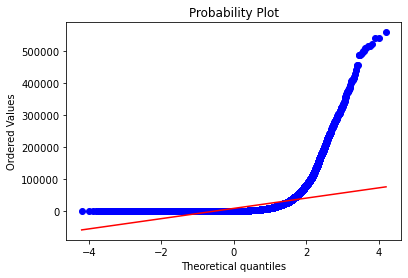

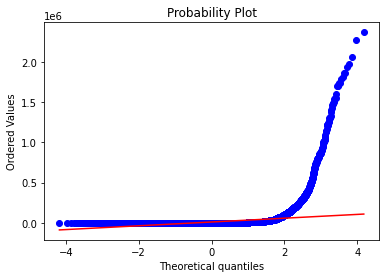

<Figure size 432x288 with 0 Axes>

In [139]:
# checking import/export values distribution
plotColGraph(im_ex_value_data[im_ex_value_data['Element'] == 'Import Value'].Value)
plotColGraph(im_ex_value_data[im_ex_value_data['Element'] == 'Export Value'].Value)

In [140]:
# using shapiro test to verify if the value data is normal
isDistNormal(im_ex_value_data.Value)

False

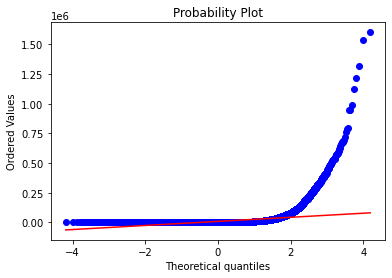

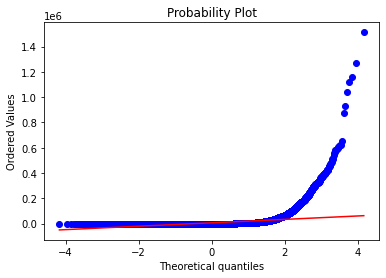

<Figure size 432x288 with 0 Axes>

In [141]:
# checking import/export quantity distribution
plotColGraph(im_ex_qtt_data[im_ex_qtt_data['Element'] == 'Import Quantity'].Value)
plotColGraph(im_ex_qtt_data[im_ex_qtt_data['Element'] == 'Export Quantity'].Value)

In [142]:
# using shapiro test to verify if the quantity data is normal
isDistNormal(im_ex_qtt_data.Value)

False

Since the import/export data of agricultural goods are not normally distributted, non-parametric tests will be applied.

- Comparing import/export data quantity and values among the countries.

In [143]:
#!pip install pingouin
from pingouin import kruskal
kruskal(data=im_ex_value_data[im_ex_value_data['Element'] == 'Import Value'], dv='Value', between='Area')

,Source,ddof1,H,p-unc
Kruskal,Area,2,758.751767,1.734392e-165


In [144]:
kruskal(data=im_ex_value_data[im_ex_value_data['Element'] == 'Export Value'], dv='Value', between='Area')

,Source,ddof1,H,p-unc
Kruskal,Area,2,2204.861176,0.0


In [145]:
kruskal(data=im_ex_qtt_data[im_ex_qtt_data['Element'] == 'Import Quantity'], dv='Value', between='Area')

,Source,ddof1,H,p-unc
Kruskal,Area,2,775.096059,4.898120e-169


In [146]:
kruskal(data=im_ex_qtt_data[im_ex_qtt_data['Element'] == 'Export Quantity'], dv='Value', between='Area')

,Source,ddof1,H,p-unc
Kruskal,Area,2,2428.513509,0.0


- Comparing import/export quantity and value in Ireland to assert the country's trade balance.

In [147]:
kruskal(data=im_ex_value_data[im_ex_value_data['Area'] == 'Ireland'], dv='Value', between='Element')

,Source,ddof1,H,p-unc
Kruskal,Element,1,1606.236287,0.0


In [148]:
for y in list(im_ex_value_data['Year'].unique()):
    k = kruskal(data=im_ex_value_data[(im_ex_value_data['Area'] == 'Ireland')&(im_ex_value_data['Year'] == y)], dv='Value', between='Element')
    print(f'Year: {y}/P-value: {k["p-unc"]}')

Year: 1961/P-value: Kruskal    0.020022
Name: p-unc, dtype: float64
Year: 1962/P-value: Kruskal    0.014893
Name: p-unc, dtype: float64
Year: 1963/P-value: Kruskal    0.006814
Name: p-unc, dtype: float64
Year: 1964/P-value: Kruskal    0.005402
Name: p-unc, dtype: float64
Year: 1965/P-value: Kruskal    0.002146
Name: p-unc, dtype: float64
Year: 1966/P-value: Kruskal    0.001155
Name: p-unc, dtype: float64
Year: 1967/P-value: Kruskal    0.000288
Name: p-unc, dtype: float64
Year: 1968/P-value: Kruskal    0.000403
Name: p-unc, dtype: float64
Year: 1969/P-value: Kruskal    0.000503
Name: p-unc, dtype: float64
Year: 1970/P-value: Kruskal    0.000383
Name: p-unc, dtype: float64
Year: 1971/P-value: Kruskal    0.000683
Name: p-unc, dtype: float64
Year: 1972/P-value: Kruskal    0.001921
Name: p-unc, dtype: float64
Year: 1973/P-value: Kruskal    0.012107
Name: p-unc, dtype: float64
Year: 1974/P-value: Kruskal    0.000115
Name: p-unc, dtype: float64
Year: 1975/P-value: Kruskal    0.000176
Name: p-

In [151]:
im_value_ire = im_ex_value_data[(im_ex_value_data['Element'] == 'Import Value')&(im_ex_value_data['Area'] == 'Ireland')]
im_value_fin = im_ex_value_data[(im_ex_value_data['Element'] == 'Import Value')&(im_ex_value_data['Area'] == 'Slovakia')]
stats.mannwhitneyu(im_value_ire['Value'], im_value_fin['Value'])

MannwhitneyuResult(statistic=95699766.0, pvalue=8.039237122231685e-60)

In [150]:
im_value_ire = im_ex_value_data[(im_ex_value_data['Element'] == 'Import Value')&(im_ex_value_data['Area'] == 'Ireland')]
ex_value_ire = im_ex_value_data[(im_ex_value_data['Element'] == 'Export Value')&(im_ex_value_data['Area'] == 'Ireland')]
stats.mannwhitneyu(im_value_ire['Value'], ex_value_ire['Value'])

MannwhitneyuResult(statistic=271192215.5, pvalue=0.0)

Based on the inferential test, Ireland's import and export values are different, which suggests a trade deficit if the country imports more than exports.

### Food price inflation

FAO provides data on the food price inflation from several countries with data from 2000 up to 2022.

Finland, Norway and Ireland have about the same population according to the Word Population Review website.

In this study, the data about the food price inflation from these countries are compared using inferntial statistics tests.

### Data Preparation

In [152]:
# showing raw dataset
dataset = pd.read_csv('./datasets/fao-food-inflation-eu.csv', encoding='utf-8')
dataset.head()

,Domain Code,Domain,Area Code (M49),Area,Year Code,Year,Item Code,Item,Months Code,Months,Unit,Value,Flag,Flag Description,Note
0,CP,Consumer Price Indices,246,Finland,2001,2001,23014,Food price inflation,7001,January,%,3.900862,E,Estimated value,NaN
1,CP,Consumer Price Indices,246,Finland,2001,2001,23014,Food price inflation,7002,February,%,2.525304,E,Estimated value,NaN
2,CP,Consumer Price Indices,246,Finland,2001,2001,23014,Food price inflation,7003,March,%,2.998384,E,Estimated value,NaN
3,CP,Consumer Price Indices,246,Finland,2001,2001,23014,Food price inflation,7004,April,%,2.810568,E,Estimated value,NaN
4,CP,Consumer Price Indices,246,Finland,2001,2001,23014,Food price inflation,7005,May,%,4.679704,E,Estimated value,NaN


In [153]:
# remove null column from dataset
dataset = dataset.drop(['Note'], axis=1)

In [154]:
isDistNormal(dataset.Value)

False

In [155]:
dataset[(dataset['Area']=='Ireland')]['Year'].unique()
dataset[(dataset['Area']=='Ireland')&(dataset['Year']==2020)]

,Domain Code,Domain,Area Code (M49),Area,Year Code,Year,Item Code,Item,Months Code,Months,Unit,Value,Flag,Flag Description
489,CP,Consumer Price Indices,372,Ireland,2020,2020,23014,Food price inflation,7001,January,%,-1.131685,E,Estimated value
490,CP,Consumer Price Indices,372,Ireland,2020,2020,23014,Food price inflation,7002,February,%,-1.030919,E,Estimated value
491,CP,Consumer Price Indices,372,Ireland,2020,2020,23014,Food price inflation,7003,March,%,-1.642709,E,Estimated value
492,CP,Consumer Price Indices,372,Ireland,2020,2020,23014,Food price inflation,7004,April,%,-1.233303,E,Estimated value
493,CP,Consumer Price Indices,372,Ireland,2020,2020,23014,Food price inflation,7005,May,%,-1.333323,E,Estimated value
494,CP,Consumer Price Indices,372,Ireland,2020,2020,23014,Food price inflation,7006,June,%,-1.544802,E,Estimated value
495,CP,Consumer Price Indices,372,Ireland,2020,2020,23014,Food price inflation,7007,July,%,-1.237107,E,Estimated value
496,CP,Consumer Price Indices,372,Ireland,2020,2020,23014,Food price inflation,7008,August,%,-1.750778,E,Estimated value
497,CP,Consumer Price Indices,372,Ireland,2020,2020,23014,Food price inflation,7009,September,%,-1.455308,E,Estimated value
498,CP,Consumer Price Indices,372,Ireland,2020,2020,23014,Food price inflation,7010,October,%,-1.557635,E,Estimated value


### Data Visualization

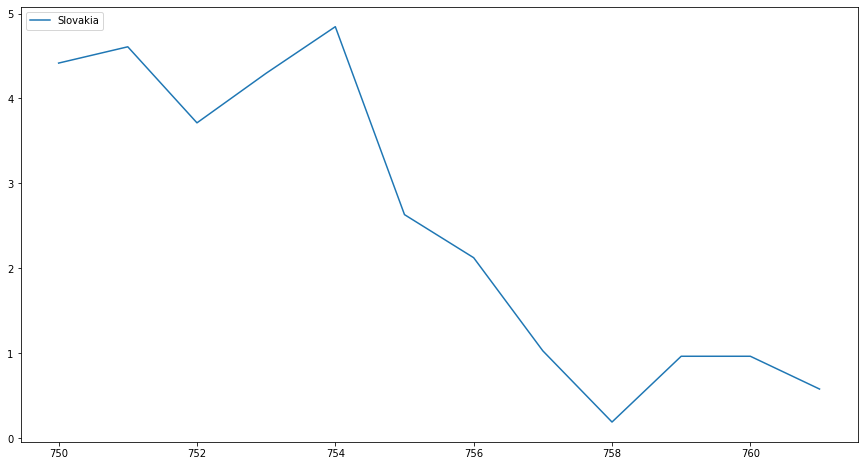

In [157]:
fig, ax = plt.subplots(figsize=(15, 8))
#ax.plot(dataset[(dataset['Area']=='Ireland')&(dataset['Year']==2020)]['Value'], label='Ireland')
ax.plot(dataset[(dataset['Area']=='Slovakia')&(dataset['Year']==2020)]['Value'], label='Slovakia')
#ax.plot(x, ire, label='Ireland')
plt.legend(loc=2)

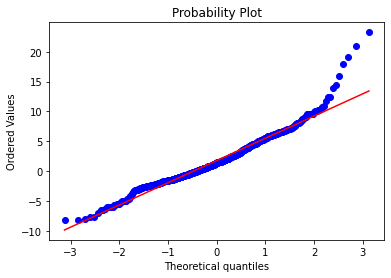

<Figure size 432x288 with 0 Axes>

In [158]:
plotColGraph(dataset.Value)

In [160]:
# use wilcoxon stats test to compare inflation between countries
from scipy.stats import wilcoxon
res = wilcoxon(dataset[dataset['Area'] == 'Ireland'].Value, dataset[dataset['Area'] == 'Finland'].Value)
res

WilcoxonResult(statistic=5750.0, pvalue=1.4845155500846593e-20)

Inflation data is different.